# Analizamos tweets con Watson NLU
En este ejercicio vamos a analizar un conjunto de tweets con python para obtener diferentes enrichments

## 1. Instalamos las librerías necesarias

In [17]:
!pip install preprocessor
!pip install textblob
# instalamos las librerías de Watson
!pip install ibm_watson


In [18]:
import json
import pandas as pd
import csv
import re #regular expression
from textblob import TextBlob
import string
import preprocessor as p
import os
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('stopwords')


[nltk_data] Downloading package punkt to /home/dsxuser/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/dsxuser/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [19]:
# Importamos las librerías de Watson Natural Languague Understanding e IBM Cloud
import sys
import os
import json
from ibm_watson import NaturalLanguageUnderstandingV1
from ibm_watson.natural_language_understanding_v1 import Features, EntitiesOptions, KeywordsOptions, CategoriesOptions, SentimentOptions, ConceptsOptions
from ibm_cloud_sdk_core.authenticators import IAMAuthenticator


In [48]:
#Credenciales NLU

authenticator = IAMAuthenticator('')
service = NaturalLanguageUnderstandingV1(
    version='2019-07-12',
    authenticator=authenticator)
service.set_service_url('')



## 2. Importamos el dataset con el conjunto de los tweets

In [49]:
# Importamos los tweets



## 3. Limpiamos los tweets para ser analizados

#### 3.1 Definimos aquellos carácteres que nos gustaría eliminar para evitar ruido

In [22]:
#Emoticones felices
emoticons_happy = set([
    ':-)', ':)', ';)', ':o)', ':]', ':3', ':c)', ':>', '=]', '8)', '=)', ':}',
    ':^)', ':-D', ':D', '8-D', '8D', 'x-D', 'xD', 'X-D', 'XD', '=-D', '=D',
    '=-3', '=3', ':-))', ":'-)", ":')", ':*', ':^*', '>:P', ':-P', ':P', 'X-P',
    'x-p', 'xp', 'XP', ':-p', ':p', '=p', ':-b', ':b', '>:)', '>;)', '>:-)',
    '<3'
    ])

In [23]:
# Emoticonos tristes
emoticons_sad = set([
    ':L', ':-/', '>:/', ':S', '>:[', ':@', ':-(', ':[', ':-||', '=L', ':<',
    ':-[', ':-<', '=\\', '=/', '>:(', ':(', '>.<', ":'-(", ":'(", ':\\', ':-c',
    ':c', ':{', '>:\\', ';('
    ])

In [24]:
#Emoji patrón
emoji_pattern = re.compile("["
         u"\U0001F600-\U0001F64F"  # emoticons
         u"\U0001F300-\U0001F5FF"  # symbols & pictographs
         u"\U0001F680-\U0001F6FF"  # transport & map symbols
         u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
         u"\U00002702-\U000027B0"
         u"\U000024C2-\U0001F251"
         "]+", flags=re.UNICODE)

In [25]:
#combinamos los emoticones tristes y felices
emoticons = emoticons_happy.union(emoticons_sad)

#### 3.2 Iniciamos el preprocesamiento de los tweets para limpiarlos 

In [26]:
## Preprocessor 

def clean_tweets(tweet):
 
   
#after tweepy preprocessing the colon symbol left remain after    
#removing urls
    filtered_tweet = re.sub(r'((http(s)?(\:\/\/))+(www\.)?([\w\-\.\/])*(\.[a-zA-Z]{2,3}\/?))[^\s\b\n|]*[^.,;:\?\!\@\^\$ -]', '', tweet)
    filtered_tweet = filtered_tweet.replace('\n', ' ')
    
#removing retweets
    filtered_tweet = re.sub(r'^(RT|rt)( @\w*)?[: ]','',filtered_tweet)

#remove emojis from tweet
    filtered_tweet = emoji_pattern.sub(r'', filtered_tweet)
    
    
    return filtered_tweet
    

#### 3.3. Definimos la función que llama a nuestro servicio de NLU

In [27]:
## Llamar a NLU

def NLU_call(text):
    respuesta = service.analyze(
        language='es',
        text = text,
        features = Features(keywords=KeywordsOptions(emotion=True, sentiment=True),
                           categories= CategoriesOptions(limit=2),
                           concepts = ConceptsOptions(limit=2),
                           sentiment=SentimentOptions(document=True))).get_result()
    return respuesta

## 4. Analizamos los tweets
Generamos una función para analizar los tweets que tenemos en el dataframe

In [28]:
# Creamos las nuevas columnas necesarias

df_tweets['filtered_tweet'] = ""
df_tweets['sentiment'] = ""
df_tweets['keywords']=""
df_tweets['concepts']=""
df_tweets['categories']=""

In [29]:
df_tweets.head(2)

id                      created_at  \
0  1245796189372637184  Thu Apr 02 19:32:11 +0000 2020   
1  1245796180904357890  Thu Apr 02 19:32:09 +0000 2020   

                                              source  \
0  <a href="https://mobile.twitter.com" rel="nofo...   
1  <a href="http://twitter.com/download/android" ...   

                                       original_text lang  favorite_count  \
0  Coronavirus en Perú: se incrementó a 55 la cif...   es               0   
1  RT @astursalud: 📌 ACTUALIZACIÓN SITUACIÓN #COV...   es               0   

   retweet_count original_author           hashtags user_mentions  \
0              0       Lima_ECpe                NaN           NaN   
1             25           egcvx  COVID19, Asturias    astursalud   

  filtered_tweet sentiment keywords concepts categories  
0                                                        
1

In [45]:
##Extracting tweets

def write_tweets():
  
    for index, row in df_tweets.iterrows():


            #call clean_tweet method for extra preprocessing
            filtered_tweet=clean_tweets(row['original_text'])


            
            #NLU extraction
            entities_text = []
            entities_type = []
            
            concepts = []
            keywords = []
            categories = []
            
            
            outputNLU_json = NLU_call(filtered_tweet)
            
           
            for keyword in outputNLU_json['keywords']:
                if keyword['relevance']>=0.6:
                    keywords.append(keyword['text'])
                    
            for concept in outputNLU_json['concepts']:
                if concept['relevance']>=0.6 and concept['text']!='Hypertext Transfer Protocol Secure':
                    concepts.append(concept['text'])
                    
            for category in outputNLU_json['categories']:
                if category['score']>=0.6:
                    categories.append(category['label'])
                  
            

           

            #update entries
            
            df_tweets.at[index,'filtered_tweet'] = filtered_tweet
            df_tweets.at[index,'sentiment'] = outputNLU_json['sentiment']['document']['label']
            df_tweets.at[index,'keywords']=keywords
            df_tweets.at[index,'concepts']=concepts
            df_tweets.at[index,'categories']=categories
        
    

In [46]:
write_tweets()

In [47]:
df_tweets.head()

id                      created_at  \
0  1245796189372637184  Thu Apr 02 19:32:11 +0000 2020   
1  1245796180904357890  Thu Apr 02 19:32:09 +0000 2020   
2  1245796172557664256  Thu Apr 02 19:32:07 +0000 2020   
3  1245796164064153606  Thu Apr 02 19:32:05 +0000 2020   
4  1245796155352666114  Thu Apr 02 19:32:03 +0000 2020   

                                              source  \
0  <a href="https://mobile.twitter.com" rel="nofo...   
1  <a href="http://twitter.com/download/android" ...   
2  <a href="http://twitter.com/download/iphone" r...   
3  <a href="http://twitter.com/download/android" ...   
4  <a href="http://twitter.com/download/iphone" r...   

                                       original_text lang  favorite_count  \
0  Coronavirus en Perú: se incrementó a 55 la cif...   es               0   
1  RT @astursalud: 📌 ACTUALIZACIÓN SITUACIÓN #COV...   es               0   
2  RT @lucas___marco: Éste es el doctor Drake Ram...   es               0   
3  RT @TelediarioEC: #TelediarioEC | El hospital ...   es               0   
4  PARAGUAYO JUNTOS 🇹🇼 Y CON USTEDES 🇵🇾 vamos a l...   es               0   

   retweet_count original_author                             hashtags  \
0              0       Lima_ECpe                                  NaN   
1             25           egcvx                    COVID19, Asturias   
2              5     andreabds25                                  NaN   
3             23     diana_Lop27  TelediarioEC, coronavirus, Covid_19   
4            314       jjbernall                                  NaN   

   user_mentions                                     filtered_tweet sentiment  \
0            NaN  Coronavirus en Perú: se incrementó a 55 la cif...  negative   
1     astursalud    ACTUALIZACIÓN SITUACIÓN #COVID19  #Asturias ...   neutral   
2  lucas___marco   Éste es el doctor Drake Ramoray, licenciado e...   neutral   
3   TelediarioEC   #TelediarioEC | El hospital 'Isidro Ayora' en...   neutral   
4            NaN  PARAGUAYO JUNTOS  Y CON USTEDES  vamos a lucha...  positive   

                                            keywords           concepts  \
0                                 [cifra de muertos]                 []   
1  [Casos activos, ACTUALIZACIÓN SITUACIÓN #COVID...   [Parche, Activo]   
2                                     [doctor Drake]                 []   
3                                     [Isidro Ayora]  [Paciente, Virus]   
4                                 [PARAGUAYO JUNTOS]                 []   

                                          categories  
0  [/health and fitness/disease/epidemic, /health...  
1  [/health and fitness/disease, /health and fitn...  
2   [/health and fitness/disease, /science/medicine]  
3             [/health and fitness/disease/epidemic]  
4                                   [/sports/boxing]

## 5. Almacenamos los el análisis generado

In [76]:
# @hidden_cell
# The project token is an authorization token that is used to access project resources like data sources, connections, and used by platform APIs.
from project_lib import Project
project = Project(project_id='', project_access_token='')
pc = project.project_context


In [77]:
project.get_files()

[{'name': 'tweets_covid19_1585910540.010699.csv',
  'asset_id': '5090aabf-766f-485d-b115-e2a248f3a3aa'},
 {'name': 'customer_churn.csv',
  'asset_id': '2c674a60-db66-42fd-8738-b24d4e02aa66'},
 {'name': 'WA_Fn-UseC_-Telco-Customer-Churn.csv',
  'asset_id': '17bb1279-b2dc-45a1-b97f-fda9f35ee784'},
 {'name': 'tweets_covid.csv_shaped.csv',
  'asset_id': '68d78dbc-42ae-4139-9576-a5c07ea6cfcc'}]

In [78]:
import datetime;
ts = datetime.datetime.now().timestamp()

project.save_data("tweets_covid19_"+ str(ts) +".csv", df_tweets.to_csv(index=False))

{'file_name': 'tweets_covid19_1585911869.813924.csv',
 'message': 'File saved to project storage.',
 'bucket_name': 'uemwatsonsesinprctica-donotdelete-pr-os2ckmhsvlligp',
 'asset_id': '089673a6-5b31-4e1d-868a-27e330f46ffc'}

## 6. Analizamos los datos extraidos

Vamos a realizar un pequeño análisis de los datos que hemos obtenido con NLU

In [127]:
df_tweets.head()

id                      created_at  \
0                   id                      created_at   
1  1245796189372637184  Thu Apr 02 19:32:11 +0000 2020   
2  1245796180904357890  Thu Apr 02 19:32:09 +0000 2020   
3  1245796172557664256  Thu Apr 02 19:32:07 +0000 2020   
4  1245796164064153606  Thu Apr 02 19:32:05 +0000 2020   

                                              source  \
0                                             source   
1  <a href="https://mobile.twitter.com" rel="nofo...   
2  <a href="http://twitter.com/download/android" ...   
3  <a href="http://twitter.com/download/iphone" r...   
4  <a href="http://twitter.com/download/android" ...   

                                       original_text  lang  favorite_count  \
0                                      original_text  lang  favorite_count   
1  Coronavirus en Perú: se incrementó a 55 la cif...    es               0   
2  RT @astursalud: 📌 ACTUALIZACIÓN SITUACIÓN #COV...    es               0   
3  RT @lucas___marco: Éste es el doctor Drake Ram...    es               0   
4  RT @TelediarioEC: #TelediarioEC | El hospital ...    es               0   

   retweet_count  original_author                             hashtags  \
0  retweet_count  original_author                             hashtags   
1              0        Lima_ECpe                                  NaN   
2             25            egcvx                    COVID19, Asturias   
3              5      andreabds25                                  NaN   
4             23      diana_Lop27  TelediarioEC, coronavirus, Covid_19   

   user_mentions                                     filtered_tweet sentiment  \
0  user_mentions                                      original_text   neutral   
1            NaN  Coronavirus en Perú: se incrementó a 55 la cif...  negative   
2     astursalud    ACTUALIZACIÓN SITUACIÓN #COVID19  #Asturias ...   neutral   
3  lucas___marco   Éste es el doctor Drake Ramoray, licenciado e...   neutral   
4   TelediarioEC   #TelediarioEC | El hospital 'Isidro Ayora' en...   neutral   

                                            keywords           concepts  \
0                                         [original]                 []   
1                                 [cifra de muertos]                 []   
2  [Casos activos, ACTUALIZACIÓN SITUACIÓN #COVID...   [Parche, Activo]   
3                                     [doctor Drake]                 []   
4                                     [Isidro Ayora]  [Paciente, Virus]   

                                          categories  
0                                                 []  
1  [/health and fitness/disease/epidemic, /health...  
2  [/health and fitness/disease, /health and fitn...  
3   [/health and fitness/disease, /science/medicine]  
4             [/health and fitness/disease/epidemic]

In [141]:
# Creamos un array con todos los keywords, concepts y categories extraídos

keywords=[]
concepts=[]
categories=[]

for keyword_array in df_tweets['keywords']:
    array = [i.lower().replace(',', '').split() for i in keyword_array]
    for keyword in array:
        keywords.append(keyword[0])

for concept_array in df_tweets['concepts']:
    array = [i.lower().replace(',', '').split() for i in concept_array] 
    for concept in array:
        concepts.append(concept[0])
        
for category_array in df_tweets['categories']:
    array = [i.lower().replace(',', '').split() for i in category_array]
    for category in array:
        categories.append(category[0])

#### 6.1 Contamos el número de apariciones de los enrichments

In [143]:

from collections import Counter
c=Counter(keywords)
c.most_common()

[('covid-19', 11),
 ('presidente', 6),
 ('casos', 5),
 ('doctor', 4),
 ('#coronavirus', 4),
 ('medidas', 3),
 ('política', 3),
 ('reacción', 3),
 ('vez', 3),
 ('cifra', 2),
 ('última', 2),
 ('tiempos', 2),
 ('pandemia', 2),
 ('mayor', 2),
 ('provincia', 2),
 ('vía', 2),
 ('gobierno', 2),
 ('alto', 2),
 ('corea', 2),
 ('hospital', 2),
 ('crisis', 2),
 ('consecuencia', 2),
 ('#nacional', 2),
 ('condena', 2),
 ('calles', 2),
 ('sociedad', 2),
 ('parte', 2),
 ('original', 1),
 ('actualización', 1),
 ('isidro', 1),
 ('paraguayo', 1),
 ('líderes', 1),
 ('tipo', 1),
 ('foto', 1),
 ('dueña', 1),
 ('única', 1),
 ('atención', 1),
 ('pagos', 1),
 ('diputada', 1),
 ('beneficios', 1),
 ('salvarnos', 1),
 ('mera', 1),
 ('causa', 1),
 ('lado', 1),
 ('afueras', 1),
 ('#ecuador', 1),
 ('plena', 1),
 ('útiles', 1),
 ('#nacionaleskw', 1),
 ('sector', 1),
 ('noche', 1),
 ('corto', 1),
 ('portal', 1),
 ('república', 1),
 ('pena', 1),
 ('máquina', 1),
 ('sistema', 1),
 ('sip', 1),
 ('cantaleta', 1),
 ('#ena

In [144]:
cc=Counter(concepts)
cc.most_common()

[('virus', 14),
 ('el', 6),
 ('la', 5),
 ('banco', 5),
 ('estados', 4),
 ('paciente', 3),
 ('contrato', 3),
 ('españa', 3),
 ('política', 3),
 ('medio', 3),
 ('guayaquil', 2),
 ('presente', 2),
 ('república', 2),
 ('sistema', 2),
 ('presidente', 2),
 ('mes', 2),
 ('día', 2),
 ('partido', 2),
 ('negligencia', 2),
 ('puntos', 2),
 ('equipo', 2),
 ('parche', 1),
 ('activo', 1),
 ('perito', 1),
 ('fotografía', 1),
 ('color', 1),
 ('beneficio', 1),
 ('evento', 1),
 ('varón', 1),
 ('lenín', 1),
 ('siglo', 1),
 ('político', 1),
 ('turismo', 1),
 ('príncipe', 1),
 ('cristina', 1),
 ('jorge', 1),
 ('país', 1),
 ('profesión', 1),
 ('filipinas', 1),
 ('padre', 1),
 ('vida', 1),
 ('máquina', 1),
 ('persona', 1),
 ('investigación', 1),
 ('antonio', 1),
 ('universidad', 1),
 ('johns', 1),
 ('cadena', 1),
 ('uxue', 1),
 ('nafarroa', 1),
 ('comunicación', 1),
 ('algoritmo', 1),
 ('aritmética', 1),
 ('juan', 1),
 ('organización', 1),
 ('transporte', 1),
 ('rápido', 1),
 ('hotel', 1),
 ('mérida', 1),
 (

In [145]:
ccat=Counter(categories)
ccat.most_common()

[('/health', 82),
 ('/law', 49),
 ('/society/unrest', 16),
 ('/business', 15),
 ('/technology', 10),
 ('/science/medicine', 6),
 ('/society/crime/personal', 6),
 ('/society/work/unemployment', 6),
 ('/religion', 6),
 ('/automotive', 6),
 ('/art', 4),
 ('/society', 4),
 ('/finance/bank', 3),
 ('/society/social', 3),
 ('/society/crime/drug', 3),
 ('/news/national', 3),
 ('/food', 3),
 ('/sports/cricket', 3),
 ('/science/chemistry/organic', 3),
 ('/society/work', 3),
 ('/finance/investing', 3),
 ('/sports/boxing', 2),
 ('/careers/nursing', 2),
 ('/finance/investing/funds', 2),
 ('/finance/bank/atms', 2),
 ('/education/homework', 2),
 ('/education/special', 2),
 ('/education/teaching', 2),
 ('/family', 2),
 ('/travel/transports/air', 2),
 ('/real', 1),
 ('/society/welfare/healthcare', 1),
 ('/sports/go', 1),
 ('/shopping/auctions', 1),
 ('/science', 1),
 ('/science/biology', 1),
 ('/pets/aquariums', 1),
 ('/sports/hunting', 1),
 ('/pets/zoo', 1),
 ('/sports/bowling', 1),
 ('/science/weathe

#### 6.2 Generamos una nube de palabras

In [148]:
!pip install wordcloud

     |████████████████████████████████| 368kB 25.6MB/s eta 0:00:01


In [154]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt


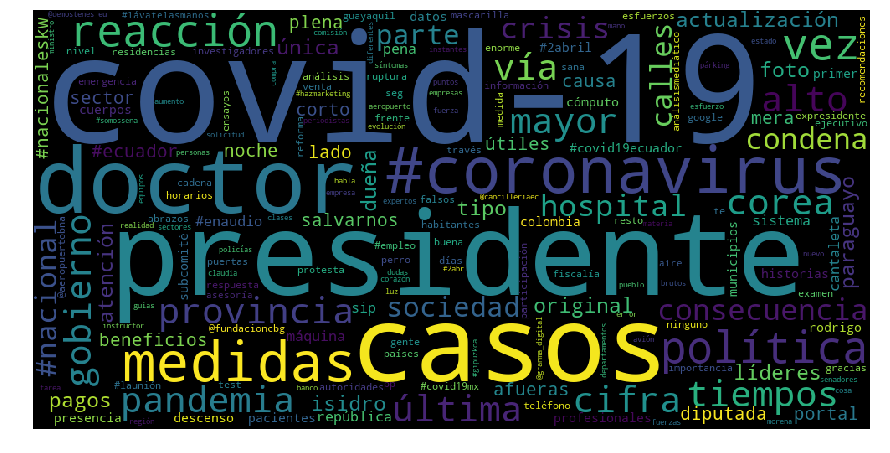

In [152]:
# Keywords
wordcloud = WordCloud(width = 1000, height = 500).generate_from_frequencies(c)

plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

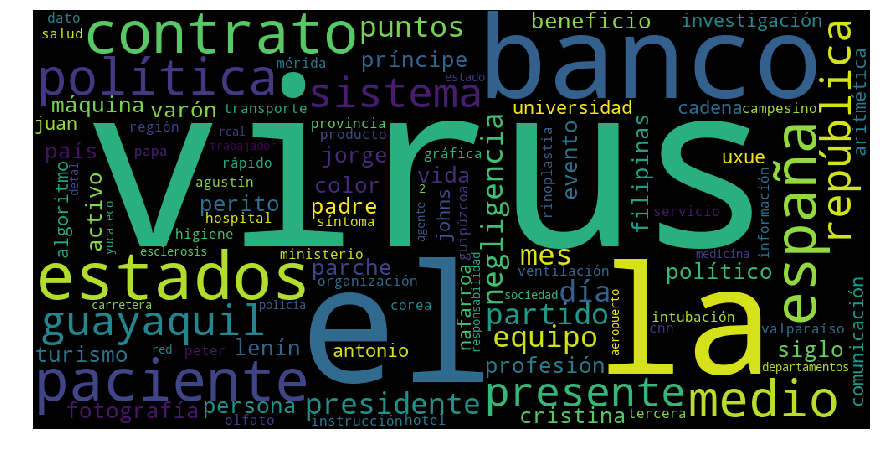

In [151]:
# Conceptos
wordcloud = WordCloud(width = 1000, height = 500).generate_from_frequencies(cc)

plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

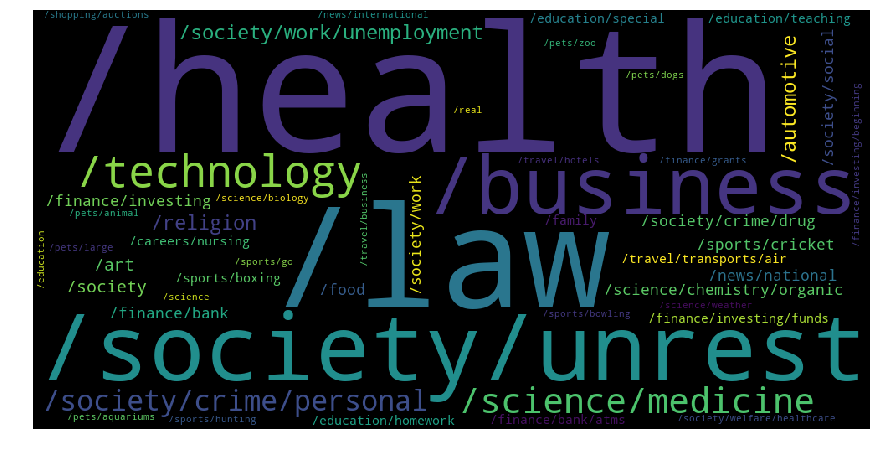

In [153]:
# Categorías
wordcloud = WordCloud(width = 1000, height = 500).generate_from_frequencies(ccat)

plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()